# Fine Tuning mBERT Amharic Text Hate Speech Detection with LoRA

In [1]:
!pip install peft
!pip install transformers
!pip install accelerate
!pip install loralib
!pip install evaluate
!pip install tqdm
!pip install datasets
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
# External Libraries
import numpy as np
import pandas as pd
import torch
import os
import gc
import seaborn as sns
import sklearn
import transformers
import matplotlib.pyplot as plt

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

# Hugging Face Datasets
import datasets
from datasets import Dataset
from datasets import load_metric, list_metrics

# Torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
!nvidia-smi

Sun Jan  7 15:01:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Dataset , Tokenizer, Base Model

In [6]:
all_dataset = datasets.load_from_disk(os.path.abspath("/content/gdrive/My Drive/Am-Hate/data/processed_data"))

In [7]:
all_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 23209
    })
    test: Dataset({
        features: ['labels', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6448
    })
    valid: Dataset({
        features: ['labels', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2579
    })
})

In [8]:
tokenizer_path = r"/content/gdrive/My Drive/Am-Hate/data/amharic_bert_tokenizer" #Load the tokenizer
base_model = 'Davlan/bert-base-multilingual-cased-finetuned-amharic' # This is a pre-trained model available on Hugging Face for different task.

In [9]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

#  Fine-Tuning Methods and Trainable Parameters
*  LoRA

In [10]:
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PromptTuningConfig,
    PromptTuningInit,
    LoraConfig,
)
p_type = "lora"
if p_type == "prompt-tuning":
  peft_type = PeftType.PROMPT_TUNING
  peft_config = PromptTuningConfig(task_type="SEQ_CLS",
                                   num_virtual_tokens=20,
                                   prompt_tuning_init=PromptTuningInit.TEXT,
                                   prompt_tuning_init_text="የኢትዮጵያ ፌዴራላዊ ዲሞክራሲያዊ ሪፐብሊክ መንግስት አይረባም",
                                   tokenizer_name_or_path=tokenizer_path)
elif p_type == "p-tuning":
  peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=300,
                                    encoder_reparameterization_type="MLP",
                                    encoder_hidden_size=128)
elif p_type == "lora":
  peft_type = PeftType.LORA
  peft_config = LoraConfig(task_type="SEQ_CLS",
                           inference_mode=False,
                           target_modules=['query','key','value','out_proj'],
                           r=16, lora_alpha=32,
                           lora_dropout=0.1)
  print(peft_type)
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=3, ignore_mismatched_sizes=True)
if p_type is not None:
  model = get_peft_model(model, peft_config)
  model.print_trainable_parameters()
else:
  def print_trainable_parameters(model):
        trainable_params = 0
        all_param = 0
        for _, param in model.named_parameters():
            num_params = param.numel()
            if num_params == 0 and hasattr(param, "ds_numel"):
                num_params = param.ds_numel

            all_param += num_params
            if param.requires_grad:
                trainable_params += num_params
        print(
            f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
        )
  print_trainable_parameters(model)

PeftType.LORA


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/798 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,043 || all params: 178,742,790 || trainable%: 0.4962678494612286


In [11]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(119547, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): 

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Class Balancing and Custom Loss

In [13]:
df = pd.read_excel('/content/gdrive/My Drive/Geez File/DeepHate/balanced_data.xlsx')
df.columns = ["labels", 'tweet']

In [14]:
# Calculate class weights to balance the loss function due to class imbalance
class_weights = (1 - (df["labels"].value_counts().sort_index()/len(df))).values
class_weights = torch.from_numpy(class_weights).float().to("cuda")
print(class_weights)

# Define a custom trainer class
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Forward Pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

tensor([0.6728, 0.6382, 0.6891], device='cuda:0')


In [15]:
#free up memory resources
gc.collect()
torch.cuda.empty_cache()

# Evaluation Metric Functions

In [27]:
def compute_metrics(eval_preds):
    # alternative compute metric function for general stats
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)
    precision = load_metric("precision").compute(predictions=predictions, references=labels,average="weighted")
    f1 = load_metric("f1").compute(predictions=predictions, references=labels,average="weighted")
    recall = load_metric("recall").compute(predictions=predictions, references=labels,average="weighted")
    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}

def compute_hate_metrics(labels: np.array, predictions: np.array) -> dict:
    true_hate_labels = (labels == 1)
    true_non_hate_labels = np.logical_not(true_hate_labels)
    pred_hate_labels = (predictions == 1)
    pred_non_hate_labels = np.logical_not(pred_hate_labels)

    tp_labels_hate = true_hate_labels & pred_hate_labels
    tn_labels_hate = true_non_hate_labels & pred_non_hate_labels
    fp_labels_hate = true_non_hate_labels & pred_hate_labels
    fn_labels_hate = true_hate_labels & pred_non_hate_labels

    tp_hate = tp_labels_hate.sum()
    tn_hate = tn_labels_hate.sum()
    fp_hate = fp_labels_hate.sum()
    fn_hate = fn_labels_hate.sum()

    hate_acc = (tp_hate + tn_hate) / (tp_hate + tn_hate + fp_hate + fn_hate)
    recall_hate = tp_hate / (tp_hate + fn_hate)
    precision_hate = tp_hate / (tp_hate + fp_hate)
    hate_f1 = 2 * (precision_hate * recall_hate) / (precision_hate + recall_hate)

    return {
        "hate_recall": recall_hate,
        "hate_precision": precision_hate,
        "hate_f1": hate_f1,
        "hate_acc":hate_acc,
    }
def compute_offens_metrics(labels: np.array, predictions: np.array) -> dict:
    true_offensive_labels = (labels == 2)
    true_non_offensive_labels = np.logical_not(true_offensive_labels)
    pred_offensive_labels = (predictions == 2)
    pred_non_offensive_labels = np.logical_not(pred_offensive_labels)

    tp_labels_offensive = true_offensive_labels & pred_offensive_labels
    tn_labels_offensive = true_non_offensive_labels & pred_non_offensive_labels
    fp_labels_offensive = true_non_offensive_labels & pred_offensive_labels
    fn_labels_offensive = true_offensive_labels & pred_non_offensive_labels

    tp_offensive = tp_labels_offensive.sum()
    tn_offensive = tn_labels_offensive.sum()
    fp_offensive = fp_labels_offensive.sum()
    fn_offensive = fn_labels_offensive.sum()

    offensive_acc = (tp_offensive + tn_offensive) / (tp_offensive + tn_offensive + fp_offensive + fn_offensive)
    recall_offensive = tp_offensive / (tp_offensive + fn_offensive)
    precision_offensive = tp_offensive / (tp_offensive + fp_offensive)
    offensive_f1 = 2 * (precision_offensive * recall_offensive) / (precision_offensive + recall_offensive)
    return {
        "offensive_recall": recall_offensive,
        "offensive_precision": precision_offensive,
        "offensive_f1": offensive_f1,
        "offensive_acc":offensive_acc,
    }
def compute_free_metrics(labels: np.array, predictions: np.array) -> dict:
    true_free_labels = (labels == 0)
    true_non_free_labels = np.logical_not(true_free_labels)
    pred_free_labels = (predictions == 0)
    pred_non_free_labels = np.logical_not(pred_free_labels)

    tp_labels_free = true_free_labels & pred_free_labels
    tn_labels_free = true_non_free_labels & pred_non_free_labels
    fp_labels_free = true_non_free_labels & pred_free_labels
    fn_labels_free = true_free_labels & pred_non_free_labels

    tp_free = tp_labels_free.sum()
    tn_free = tn_labels_free.sum()
    fp_free = fp_labels_free.sum()
    fn_free = fn_labels_free.sum()

    free_acc = (tp_free + tn_free) / (tp_free + tn_free + fp_free + fn_free)
    recall_free = tp_free / (tp_free + fn_free)
    precision_free = tp_free / (tp_free + fp_free)
    free_f1 = 2 * (precision_free * recall_free) / (precision_free + recall_free)

    return {
        "free_recall": recall_free,
        "free_precision": precision_free,
        "free_f1": free_f1,
        "free_acc":free_acc,
    }

def compute_accuracy_f1(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    metrics1 = compute_hate_metrics(labels, predictions)
    metrics2 = compute_offens_metrics(labels, predictions)
    metrics3 = compute_free_metrics(labels, predictions)
    return {"hatef1": metrics1["hate_f1"],
            "offensivef1": metrics2["offensive_f1"],
            "freef1": metrics3["free_f1"],
            "hate_acc": metrics1["hate_acc"],
            "offensive_acc": metrics2["offensive_acc"],
            "free_acc": metrics3["free_acc"],
            }
training_args = TrainingArguments(
    output_dir="/content/gdrive/My Drive/Am-Hate/results",
    load_best_model_at_end = True,
    metric_for_best_model = "eval_hatef1",
    warmup_steps=500,
    fp16=True,
    learning_rate=  2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    logging_dir = "/content/gdrive/My Drive/Am-Hate/logs",
    logging_steps = 100,
    eval_steps = 500,
    save_steps =500,
)
trainer = CustomTrainer(
    model = model,
    args=training_args,
    train_dataset=all_dataset["train"],
    eval_dataset=all_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_accuracy_f1,
)

# Training

In [28]:
import datetime
model_path = "/content/gdrive/My Drive/Am-Hate/results/training_begin=" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
trainer.train()

Step,Training Loss,Validation Loss,Hatef1,Offensivef1,Freef1,Hate Acc,Offensive Acc,Free Acc
500,0.377100,1.384404,0.630025,0.563340,0.544944,0.718108,0.760760,0.685925
1000,0.906100,0.861240,0.671526,0.591398,0.555831,0.737883,0.764250,0.722373
1500,0.868900,0.846356,0.662480,0.642202,0.557552,0.749903,0.758046,0.742148
2000,0.822600,0.826996,0.682277,0.646729,0.538182,0.731679,0.780147,0.753781
2500,0.799400,0.820850,0.684454,0.626926,0.614219,0.761535,0.784025,0.743311
3000,0.794300,0.811784,0.660803,0.659941,0.607013,0.760760,0.777821,0.747964
3500,0.791600,0.808380,0.679717,0.663860,0.609903,0.771617,0.783249,0.749515
4000,0.800300,0.799912,0.687169,0.659833,0.625365,0.771229,0.794106,0.751454
4500,0.724000,0.815107,0.675885,0.672716,0.619918,0.772780,0.790229,0.749903
5000,0.756100,0.794171,0.671179,0.677616,0.634118,0.773943,0.794494,0.753005


TrainOutput(global_step=7255, training_loss=0.7659330750563323, metrics={'train_runtime': 1058.8751, 'train_samples_per_second': 109.593, 'train_steps_per_second': 6.852, 'total_flos': 7712304683051520.0, 'train_loss': 0.7659330750563323, 'epoch': 5.0})

# Plot results

In [29]:
train_logs = trainer.state.log_history

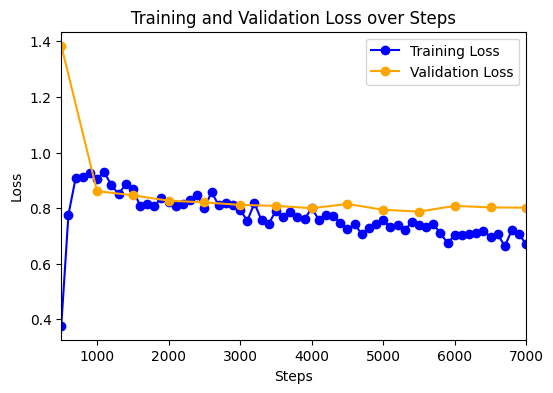

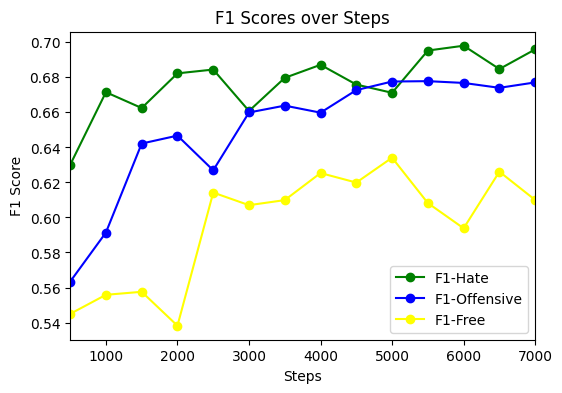

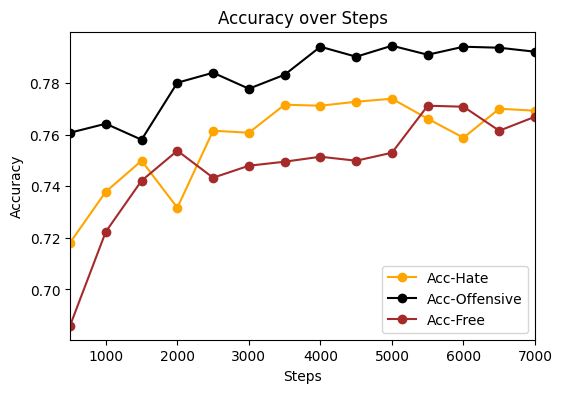

In [30]:
import matplotlib.pyplot as plt

# Assuming trainer.log_history is a list of dictionaries
train_logs = [entry for entry in trainer.state.log_history if 'loss' in entry]
eval_logs = [entry for entry in trainer.state.log_history if 'eval_loss' in entry]

# Extract information for training
train_steps = [entry['step'] for entry in train_logs]
train_loss = [entry['loss'] for entry in train_logs]

# Extract information for evaluation
eval_steps = [entry['step'] for entry in eval_logs]
eval_loss = [entry['eval_loss'] for entry in eval_logs]
eval_f1_hate = [entry['eval_hatef1'] for entry in eval_logs]
eval_f1_offensive = [entry['eval_offensivef1'] for entry in eval_logs]
eval_f1_free = [entry['eval_freef1'] for entry in eval_logs]
eval_acc_hate = [entry['eval_hate_acc'] for entry in eval_logs]
eval_acc_offensive = [entry['eval_offensive_acc'] for entry in eval_logs]
eval_acc_free = [entry['eval_free_acc'] for entry in eval_logs]

# Create and save the first plot
plt.figure(figsize=(6, 4))
plt.plot(train_steps, train_loss, label="Training Loss", color='blue', marker='o')
plt.plot(eval_steps, eval_loss, label="Validation Loss", color='orange', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.xlim(eval_steps[0], eval_steps[-1])
plt.savefig('/content/gdrive/My Drive/Am-Hate/Bloss.png')
plt.show()

# Create and save the second plot
plt.figure(figsize=(6, 4))
plt.plot(eval_steps, eval_f1_hate, label="F1-Hate", color='green', marker='o')
plt.plot(eval_steps, eval_f1_offensive, label="F1-Offensive", color='blue', marker='o')
plt.plot(eval_steps, eval_f1_free, label="F1-Free", color='yellow', marker='o')
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Scores over Steps")
plt.legend()
plt.xlim(eval_steps[0], eval_steps[-1])
plt.savefig('/content/gdrive/My Drive/Am-Hate/BF1.png')
plt.show()

# Create and save the third plot
plt.figure(figsize=(6, 4))
plt.plot(eval_steps, eval_acc_hate, label="Acc-Hate", color='orange', marker='o')
plt.plot(eval_steps, eval_acc_offensive, label="Acc-Offensive", color='black', marker='o')
plt.plot(eval_steps, eval_acc_free, label="Acc-Free", color='brown', marker='o')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy over Steps")
plt.legend()
plt.xlim(eval_steps[0], eval_steps[-1])
plt.savefig('/content/gdrive/My Drive/Am-Hate/BAc.png')
plt.show()


# Evaluate the model by test dataset

In [31]:
sample_test= all_dataset["test"]
trainer.evaluate(sample_test)

{'eval_loss': 0.8449023962020874,
 'eval_hatef1': 0.6781200631911531,
 'eval_offensivef1': 0.6537313432835822,
 'eval_freef1': 0.6033578174186779,
 'eval_hate_acc': 0.7472084367245657,
 'eval_offensive_acc': 0.7841191066997518,
 'eval_free_acc': 0.7655086848635235,
 'eval_runtime': 21.2032,
 'eval_samples_per_second': 304.104,
 'eval_steps_per_second': 19.007,
 'epoch': 5.0}

# Push Model to Huging Face

In [ ]:
!pip install huggingface_hub


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("Gizachew/amharic-roberta-lora-new_fine-tuned",
                  use_auth_token=True,
                  commit_message="hatespeech",
                  private=True)

# Load the Fine-Tuned Adapter Moodel

In [32]:
# import torch
# from peft import PeftModel, PeftConfig
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# peft_model_id = "Gizachew/amharic-bert-lora-new_fine-tuned"
# config = PeftConfig.from_pretrained(peft_model_id)
# model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path, return_dict=True, num_labels=3, ignore_mismatched_sizes=True)
# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# # Load the Lora model
# model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
# model

#Predictions of fine-tuned model with test dataset

In [33]:
predictions = trainer.predict(all_dataset["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(6448, 3) (6448,)


In [34]:
y_preds = np.argmax(predictions.predictions, axis=-1) #get predictions

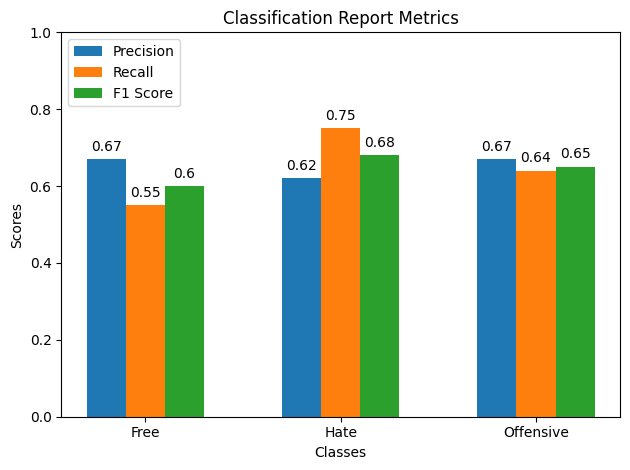

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize

# Create a classification report
report = classification_report(predictions.label_ids, y_preds, target_names=['Free', 'Hate', 'Offensive'])

# Parse the classification report to extract precision, recall, and F1-score
lines = report.split('\n')[2:-5]  # Extract relevant lines
class_names = [line.split()[0] for line in lines]
precision = [float(line.split()[1]) for line in lines]
recall = [float(line.split()[2]) for line in lines]
f1_score = [float(line.split()[3]) for line in lines]

# Plot the metrics
x = np.arange(len(class_names))
width = 0.2  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(loc='upper left')

ax.set_ylim(0, 1)

# Display the values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig('/content/gdrive/My Drive/Am-Hate/MainBreport.png')
# Show the plot
plt.show()


In [36]:
print(classification_report(y_true=predictions.label_ids,y_pred = y_preds, target_names=["free","hate", "offensive"]))

              precision    recall  f1-score   support

        free       0.67      0.55      0.60      2105
        hate       0.62      0.75      0.68      2295
   offensive       0.67      0.64      0.65      2048

    accuracy                           0.65      6448
   macro avg       0.65      0.65      0.65      6448
weighted avg       0.65      0.65      0.65      6448



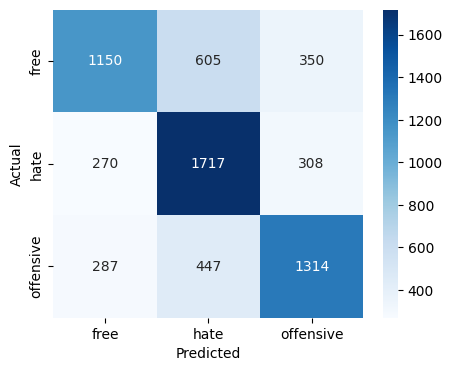

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

target_names = ("free","hate", "offensive")
cm = confusion_matrix(y_true=predictions.label_ids, y_pred=y_preds)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Save the figure before showing it
plt.savefig("/content/gdrive/My Drive/Am-Hate/CMBNewlastNon.png")

# Show the plot
plt.show()


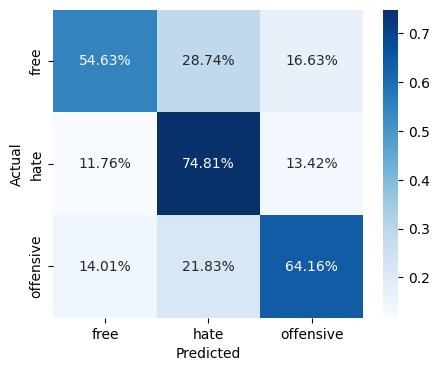

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

target_names = ("free", "hate", "offensive")
cm = confusion_matrix(y_true=predictions.label_ids, y_pred=y_preds)

# Calculate row-wise percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Save the figure before showing it
plt.savefig("/content/gdrive/My Drive/Am-Hate/CMBNewlastNon_percentage.png")

# Show the plot
plt.show()
